## Постановка задачи от бизнесa

В файле train_data.csv содержатся данные о продажах магазина в период с 01.12.10 по 31.10.11. 
Для каждого клиента, который делал заказ в период с 01.12.10 по 31.10.11, необходимо спрогнозировать вероятность совершения заказа в период с 01.11.11 по 30.11.11. 

## Интрепретация задачи и план работы с данными

Т.к. у нас уже есть информация "из будущего" то мы можем провести бинарную классификацию клиентов, зная тех, кто купил что-то с 01.11.11 по 30.11.11 и тех кто не купил.

У нас есть набор транзакционных данных о покупках пользователей,который нужно перевести в признаковое пространство обектов (CustomerID).

Необходимо агрегировать информацию о пользователях, на основании истории их покупок. Это можно делать как группировками с попутным обогащением признаков, так и использую методы машинного обучения без учителя. 

В результате заказчик попросил вывести вероятность по каждому пользователю, чтобы в дальнейшем передать в одел маркетинга.

План работ:
1. [Открытие данных](#start)
2. [Предобработка данных](#preprocessing)
3. [Исследовательский анализ данных](#research)
4. [Выбор метрики  качества машинного обучения](#metric)
5. [Обучение моделей](#fit)
6. [Проверка модели на тестовой выборке](#сheсk)
7. [Расчет вероятностей покупки в следующем месяце](#prob)
8. [Примение моделей](#apply)
9. [Рекомендации по усовершенстованию моеделей](#improve)

### Импорт библиотек 

In [1]:
import pandas as pd
import numpy as np
import random
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle


from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score,recall_score,r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer, precision_recall_curve,roc_curve
from IPython import display as display1
#Grapthics
from sklearn.tree import export_graphviz 
import matplotlib.pyplot as plt
import seaborn as sns

#options
pd.set_option("precision", 2)
np.set_printoptions(precision=2)
pd.options.mode.chained_assignment = None  # default='warn'

### Откроем файл с данными и изучите общую информацию.<a id='start'></a>

In [2]:
df = pd.read_csv('train_data.csv',sep=';')

In [3]:
df = df.sort_values(by=['InvoiceDate'])

In [4]:
df[-20:]

,InvoiceNo,ProductID,Name,Quantity,InvoiceDate,PricePerItem,CustomerID,Country
428341,573421,22197,POPCORN HOLDER,100,31.10.11 9:50,0.72,14292.0,United Kingdom
428335,573421,23339,EGG FRYING PAN BLUE,6,31.10.11 9:50,2.08,14292.0,United Kingdom
428346,573421,23247,BISCUIT TIN 50'S CHRISTMAS,6,31.10.11 9:50,2.89,14292.0,United Kingdom
428344,573421,15056BL,EDWARDIAN PARASOL BLACK,60,31.10.11 9:50,4.95,14292.0,United Kingdom
428343,573421,85014A,BLACK/BLUE POLKADOT UMBRELLA,48,31.10.11 9:50,4.95,14292.0,United Kingdom
428342,573421,20679,EDWARDIAN PARASOL RED,60,31.10.11 9:50,4.95,14292.0,United Kingdom
428345,573421,22813,PACK 3 BOXES BIRD PANNETONE,12,31.10.11 9:50,1.95,14292.0,United Kingdom
428339,573421,23161,REGENCY CAKE FORK,24,31.10.11 9:50,1.25,14292.0,United Kingdom
428338,573421,23173,REGENCY TEAPOT ROSES,12,31.10.11 9:50,8.15,14292.0,United Kingdom
428337,573421,23336,EGG FRYING PAN PINK,6,31.10.11 9:50,2.08,14292.0,United Kingdom


In [5]:
df.isnull().sum()

InvoiceNo            0
ProductID            0
Name              1364
Quantity             0
InvoiceDate          0
PricePerItem         0
CustomerID      108103
Country              0
dtype: int64

### Предобработка данных<a id="preprocessing"></a>

#### Преобразование типов данных

In [6]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df['Quantity'] = df['Quantity'].astype('int')

In [7]:
df['not_null'] = df.notnull().all(axis=1).map({True : 1,False : 0})

In [8]:
#посмотрим сколько значений с пропусками
df['not_null'].value_counts()

1    323570
0    108103
Name: not_null, dtype: int64

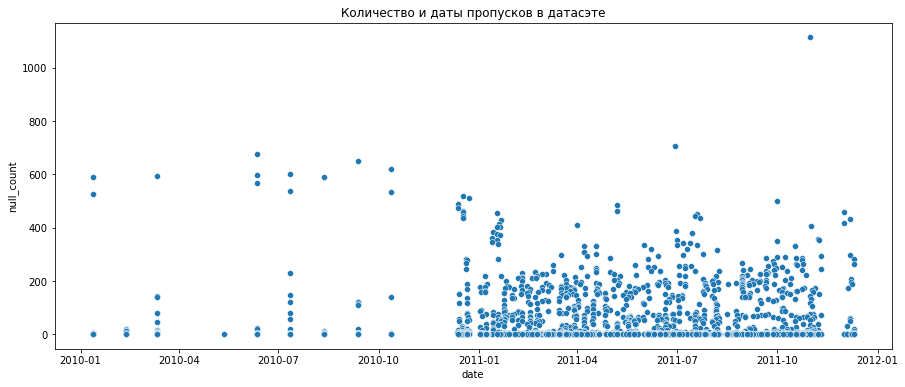

In [9]:
# когда были пропуски в датасэте
df_null = df[~df.notnull().all(axis=1)]['InvoiceDate'].value_counts().reset_index()
df_null.columns=['date','null_count']
df_null['date'] = df_null['date'].dt.date
df_null.groupby(['date']).sum().reset_index()


plt.rcParams['figure.figsize'] = (15.0, 6.0)
ax = sns.scatterplot(data=df_null, x="date", y="null_count")
ax.set(title = "Количество и даты пропусков в датасэте");

Видим, что в течении года периодически были сбои в данных.Особенно в 2011 году.

#### Удаление пропусков и дубликатов

In [10]:
print(df.duplicated().value_counts())

# удалим явные дубликаты
df=df.drop_duplicates()

False    428052
True       3621
dtype: int64


Мы нашли 3600 полных дубликатов, удалим их.

In [11]:
df=df.dropna(subset=['CustomerID'])
df = df.drop(['not_null'],axis=1)

In [12]:
df.describe()

,Quantity,PricePerItem,CustomerID
count,319990.00,319990.00,319990.00
mean,12.57,3.61,15267.02
std,191.88,77.82,1713.03
min,-74215.00,0.00,12346.00
25%,2.00,1.25,13883.00
50%,6.00,1.95,15122.00
75%,12.00,3.75,16770.00
max,74215.00,38970.00,18287.00


Видим аномальные значения в количестве и цене, будем дальше чистить эти данные.

In [13]:
# теперь нет пропусков, можно поменять тип данных у пользователей
df['CustomerID'] = df['CustomerID'].astype('int')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319990 entries, 77750 to 428353
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     319990 non-null  object        
 1   ProductID     319990 non-null  object        
 2   Name          319990 non-null  object        
 3   Quantity      319990 non-null  int32         
 4   InvoiceDate   319990 non-null  datetime64[ns]
 5   PricePerItem  319990 non-null  float64       
 6   CustomerID    319990 non-null  int32         
 7   Country       319990 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(2), object(4)
memory usage: 19.5+ MB


Перед нами датасэт с 431 тысячю записей, из которых 108 тысяч записей без CustomerID, эти записи придется удалить. Так же мы нашли пропуски в наименовании товара, но они входили в подмножество пропусков CustomerID

### Проверка данных на адекватность

#### Поиск неявных дубликатов

В даном разделе мы собрали гипотезы и будем их проверять:
- одному ID товара должна соответствовать только одна запись.
- все ID товаров и клиентов должны быть уникальны
- Не должно быть дубликатов
- количество товаров, цена не должна быть отридцательной и не превышать разумную величину


`посмотрим связку'ProductID','Name', вычислим их дубликаты`

In [15]:
# посмотрим в разрезе ProductID
duplicate_ProductID_df = pd.DataFrame(df[['ProductID','Name']].drop_duplicates()[['ProductID']].value_counts(),\
                                   columns=['value']).reset_index()
duplicate_ProductID = duplicate_ProductID_df[duplicate_ProductID_df['value'] >1]['ProductID'].unique()
duplicate_ProductID_compare = df[['ProductID','Name']].drop_duplicates().query('ProductID in @duplicate_ProductID')\
                            .sort_values(by='ProductID')
print("Количество ID где есть дубликаты",duplicate_ProductID.shape[0])
print("Общее количество строк где есть дубликаты по ProductID --  ",duplicate_ProductID_compare.shape[0])

# один из примеров записей
duplicate_ProductID_compare = duplicate_ProductID_compare.join(df[['InvoiceDate','PricePerItem']],how='left')
#display(duplicate_ProductID_compare[duplicate_ProductID_compare['ProductID']=='23283'])
duplicate_ProductID_compare

Количество ID где есть дубликаты 198
Общее количество строк где есть дубликаты по ProductID --   415


,ProductID,Name,InvoiceDate,PricePerItem
252085,16156L,WRAP CAROUSEL,2011-06-07 10:10:00,0.42
108353,16156L,WRAP. CAROUSEL,2011-03-03 13:45:00,0.42
333553,17107D,FLOWER FAIRY 5 DRAWER LINERS,2011-09-09 14:14:00,2.55
211064,17107D,FLOWER FAIRY.5 SUMMER B'DRAW LINERS,2011-02-06 11:33:00,2.55
347764,17107D,FLOWER FAIRY 5 SUMMER DRAW LINERS,2011-09-19 15:00:00,2.55
...,...,...,...,...
4239,85185B,PINK HORSE SOCK PUPPET,2010-02-12 14:09:00,2.95
386644,90014A,SILVER M.O.P. ORBIT NECKLACE,2011-09-10 15:24:00,2.95
292357,90014A,SILVER/MOP ORBIT NECKLACE,2011-05-08 16:19:00,9.95
386649,90014B,GOLD M.O.P. ORBIT NECKLACE,2011-09-10 15:24:00,2.95


Предварительно выяснили, что в 788 `ProductID` есть дубликаты (от 2 до 4 записей на каждый ID). Если смотреть по имени товаров, то подрузамевается тот же самый смысл, но есть разная цена. Так же в других примерах записи отличаются наличием точек, переиначиванием сокращений. Сделаем предположение, что эти дубли созданы при вводе, т.к. в какой то момент ПО не позволяло обновить текущую карточку товара и приходилось создавать новую запись в базе данных. 
<br><br>
В рамках задачи предсказания оттока этот недостаток не должен помешать нам, но разработчикам ПО нужно посмотреть на коренные причины неконсистентности данных.


In [16]:
# посмотрим в разрезе ProductID
duplicate_name_df = pd.DataFrame(df[['ProductID','Name']].drop_duplicates()[['Name']].value_counts(),\
                                   columns=['value']).reset_index()
duplicate_name = duplicate_name_df[duplicate_name_df['value'] >1]['Name'].unique()
duplicate_name_compare = df[['ProductID','Name']].drop_duplicates().query('Name in @duplicate_name')\
                            .sort_values(by='Name')
print("Общее количество строк где есть дубликаты по полю Name --- ",duplicate_name_compare.shape[0])
duplicate_name_compare


Общее количество строк где есть дубликаты по полю Name ---  39


,ProductID,Name
105619,10133,COLOURING PENCILS BROWN TUBE
105620,10135,COLOURING PENCILS BROWN TUBE
12120,72131,COLUMBIAN CANDLE RECTANGLE
371522,72133,COLUMBIAN CANDLE RECTANGLE
143352,72130,COLUMBIAN CANDLE ROUND
107396,72128,COLUMBIAN CANDLE ROUND
49856,85023B,EAU DE NILE JEWELLED PHOTOFRAME
288964,85024B,EAU DE NILE JEWELLED PHOTOFRAME
210646,20840,FRENCH FLORAL CUSHION COVER
371840,20837,FRENCH FLORAL CUSHION COVER


In [17]:
df[['ProductID','Name']].drop_duplicates()[['Name']].value_counts()

Name                              
METAL SIGN.CUPCAKE SINGLE HOOK        3
FRENCH FLORAL CUSHION COVER           2
WHITE BAMBOO RIBS LAMPSHADE           2
PINK FLOCK GLASS CANDLEHOLDER         2
PAPER LANTERN 9 POINT SNOW STAR       2
                                     ..
PLAYING CARDS VINTAGE DOILEY          1
PLAYING CARDS KEEP CALM & CARRY ON    1
PLAYING CARDS JUBILEE UNION JACK      1
PLAYING CARDS I LOVE LONDON           1
 4 PURPLE FLOCK DINNER CANDLES        1
Length: 3829, dtype: int64

Заметим,что в некоторых случаях ID состоит не только из цифр. Во многих случаях видно что добавляли доплнительно латинские символы. Найдем все связанные `ProductID` в которых не только цифры

In [18]:
df[df['ProductID'].str.contains('[A-Z]')]['ProductID']

77748      82494L
77753        POST
77761      84795B
77781      85014A
77805      84970S
           ...   
428298     84970L
428302     85099B
428303     85099F
428344    15056BL
428343     85014A
Name: ProductID, Length: 29571, dtype: object

In [19]:
no_digit_id = df[df['ProductID'].str.contains('[^0-9]')]['ProductID']
print("Количество ID где есть иные значения кроме цифр -- ",no_digit_id.shape[0])
no_digit_id.str.contains('[0-9]')
#убираем буквы
no_digit_id.str.extract('([0-9]+)')
#cобираем не цифровые индексы
id_no_digit = df[df['ProductID'].str.contains('^[^0-9]')]['ProductID'].unique()#\D
print("Выведем все ID которые не начинаются с цифр")
display(id_no_digit)

Количество ID где есть иные значения кроме цифр --  29571
Выведем все ID которые не начинаются с цифр


array(['POST', 'M', 'C2', 'D', 'CRUK', 'DOT', 'BANK CHARGES', 'PADS'],
      dtype=object)

In [20]:
no_id_df = df.query('ProductID in @id_no_digit ')
display(no_id_df[150:170])
no_id_df['ProductID'].unique()
no_id_df_index= no_id_df.index

,InvoiceNo,ProductID,Name,Quantity,InvoiceDate,PricePerItem,CustomerID,Country
144830,C548830,M,Manual,-1,2011-04-04 13:08:00,162.60,12744,Singapore
144831,C548830,M,Manual,-1,2011-04-04 13:08:00,2382.92,12744,Singapore
144832,C548830,M,Manual,-1,2011-04-04 13:08:00,239.30,12744,Singapore
144834,C548834,M,Manual,-1,2011-04-04 13:09:00,2053.07,12744,Singapore
144858,548858,C2,CARRIAGE,1,2011-04-04 13:29:00,50.00,14911,EIRE
144949,548860,M,Manual,1,2011-04-04 13:38:00,2.00,13263,United Kingdom
144100,548725,POST,POSTAGE,1,2011-04-04 09:08:00,134.00,12678,France
174488,551818,POST,POSTAGE,4,2011-04-05 11:57:00,18.00,12569,Germany
174514,551820,POST,POSTAGE,2,2011-04-05 12:11:00,18.00,12645,Germany
175005,551868,POST,POSTAGE,8,2011-04-05 16:29:00,28.00,12540,Spain


Мы нашли 1565 строк откровенного мусора, удалим его

In [21]:
 df = df.query('index not in @no_id_df_index')

### Отрицательное количество

,date,null_count
0,2011-06-10,223
1,2011-12-10,154
2,2011-08-31,107
3,2011-09-21,94
4,2011-10-24,88
...,...,...
263,2011-07-27,2
264,2011-05-29,2
265,2011-04-17,2
266,2011-07-31,1


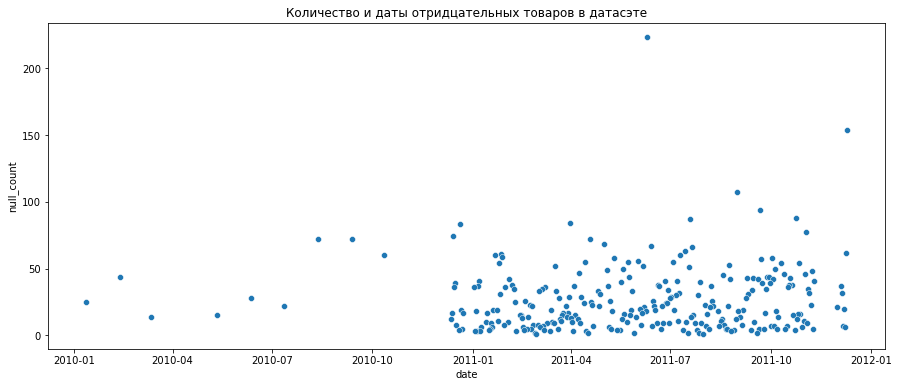

In [22]:
df_quantity_0 = pd.DataFrame(df.query('Quantity<0')['InvoiceDate'].dt.date,columns=['InvoiceDate'])
df_quantity_0 = df_quantity_0['InvoiceDate'].value_counts().reset_index()
df_quantity_0.columns=['date','null_count']
ax = sns.scatterplot(data=df_quantity_0, x='date', y='null_count')
ax.set(title = "Количество и даты отридцательных товаров в датасэте");           
df_quantity_0

In [23]:
df.query("'2011-06-11' >InvoiceDate > '2011-06-10'").sort_values(by='InvoiceDate')[-115:-105]

,InvoiceNo,ProductID,Name,Quantity,InvoiceDate,PricePerItem,CustomerID,Country
382944,569983,22766,PHOTO FRAME CORNICE,4,2011-06-10 19:49:00,2.95,17231,United Kingdom
382945,569983,23245,SET OF 3 REGENCY CAKE TINS,4,2011-06-10 19:49:00,4.95,17231,United Kingdom
382943,569983,84946,ANTIQUE SILVER T-LIGHT GLASS,12,2011-06-10 19:49:00,1.25,17231,United Kingdom
382947,569983,23524,WALL ART HORSE & PONY,1,2011-06-10 19:49:00,3.75,17231,United Kingdom
382948,569983,23527,WALL ART ANIMALS AND NATURE,1,2011-06-10 19:49:00,3.75,17231,United Kingdom
382946,569983,23315,IVORY REFECTORY CLOCK,1,2011-06-10 19:49:00,9.95,17231,United Kingdom
382980,C569984,22166,WALL MIRROR RECTANGLE DIAMANTE PINK,-1,2011-06-10 19:50:00,7.95,17231,United Kingdom
382983,C569985,22139,RETROSPOT TEA SET CERAMIC 11 PC,-3,2011-06-10 19:51:00,4.95,15365,United Kingdom
382988,C569985,16161U,WRAP SUKI AND FRIENDS,-25,2011-06-10 19:51:00,0.42,15365,United Kingdom
382984,C569985,21915,RED HARMONICA IN BOX,-12,2011-06-10 19:51:00,1.25,15365,United Kingdom


In [24]:
df.query("'2011-06-14' >InvoiceDate > '2011-06-10'").sort_values(by='InvoiceDate')[2805:2815]

,InvoiceNo,ProductID,Name,Quantity,InvoiceDate,PricePerItem,CustomerID,Country
383083,C569996,23221,REINDEER HEART DECORATION SILVER,-12,2011-06-10 20:38:00,0.83,15322,United Kingdom
383084,C569996,23118,PARISIENNE JEWELLERY DRAWER,-2,2011-06-10 20:38:00,7.50,15322,United Kingdom
383085,C569996,23112,PARISIENNE CURIO CABINET,-2,2011-06-10 20:38:00,7.50,15322,United Kingdom
383086,C569996,79191C,RETRO PLASTIC ELEPHANT TRAY,-12,2011-06-10 20:38:00,0.85,15322,United Kingdom
383087,C569996,79066K,RETRO MOD TRAY,-1,2011-06-10 20:38:00,0.85,15322,United Kingdom
223971,556500,22179,SET 10 NIGHT OWL LIGHTS,2,2011-06-13 07:58:00,6.75,13468,United Kingdom
223966,556500,22776,SWEETHEART CAKESTAND 3 TIER,2,2011-06-13 07:58:00,9.95,13468,United Kingdom
223968,556500,23174,REGENCY SUGAR BOWL GREEN,4,2011-06-13 07:58:00,4.15,13468,United Kingdom
223969,556500,23175,REGENCY MILK JUG PINK,4,2011-06-13 07:58:00,3.25,13468,United Kingdom
223970,556500,23093,SMALL PARISIENNE HEART PHOTO FRAME,8,2011-06-13 07:58:00,2.49,13468,United Kingdom


Проанализируя один из дней мы видим, что в течении 50 минут писались данные. Потом была выявлена ошибка и магазин переставал работать на какое-то время. Первоначально было предположение что это возвраты, но гипотеза не подтвердилась.

In [25]:
df['Quantity']=df['Quantity'].abs()

#### Цена равна нулю

In [26]:
zero_price = df.query('PricePerItem <=0')['InvoiceNo'].unique()
df.query('InvoiceNo in @zero_price')[:20]

,InvoiceNo,ProductID,Name,Quantity,InvoiceDate,PricePerItem,CustomerID,Country
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.00,14410,United Kingdom
145207,548871,22162,HEART GARLAND RUSTIC PADDED,4,2011-04-04 14:42:00,2.95,14410,United Kingdom
145206,548871,85186C,BUNNY EGG GARLAND,24,2011-04-04 14:42:00,0.42,14410,United Kingdom
145205,548871,84452,METAL RABBIT LADDER EASTER,12,2011-04-04 14:42:00,0.85,14410,United Kingdom
145204,548871,22859,EASTER TIN BUNNY BOUQUET,12,2011-04-04 14:42:00,1.65,14410,United Kingdom
145203,548871,22858,EASTER TIN KEEPSAKE,12,2011-04-04 14:42:00,1.65,14410,United Kingdom
145202,548871,22860,EASTER TIN CHICKS PINK DAISY,12,2011-04-04 14:42:00,1.65,14410,United Kingdom
9301,537197,22624,IVORY KITCHEN SCALES,2,2010-05-12 14:02:00,8.50,12647,Germany
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-05-12 14:02:00,0.00,12647,Germany
9303,537197,22847,BREAD BIN DINER STYLE IVORY,1,2010-05-12 14:02:00,16.95,12647,Germany


Не похоже чтобы нулевой ценой шел товар "в подарок". посчитаем это выбросами и удалим 22 сроки.

In [27]:
df = df.query('PricePerItem > 0')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318408 entries, 77750 to 428353
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     318408 non-null  object        
 1   ProductID     318408 non-null  object        
 2   Name          318408 non-null  object        
 3   Quantity      318408 non-null  int32         
 4   InvoiceDate   318408 non-null  datetime64[ns]
 5   PricePerItem  318408 non-null  float64       
 6   CustomerID    318408 non-null  int32         
 7   Country       318408 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(2), object(4)
memory usage: 19.4+ MB


In [29]:
#сгруппируем по инвойсам и посмотрим дублкикаты в связки инвойс/дата
agg = pd.DataFrame(df.groupby(['InvoiceNo','InvoiceDate'])['PricePerItem'].count()).reset_index()

In [30]:
agg_dupl = agg[agg.duplicated(subset=['InvoiceNo'],keep=False)].sort_values(by=['InvoiceNo'])
agg_dupl[:10]

,InvoiceNo,InvoiceDate,PricePerItem
116,536591,2010-01-12 16:57:00,34
117,536591,2010-01-12 16:58:00,6
1465,540185,2011-05-01 13:40:00,19
1466,540185,2011-05-01 13:41:00,10
1959,541596,2011-01-19 16:18:00,33
1960,541596,2011-01-19 16:19:00,70
1971,541631,2011-01-20 10:47:00,27
1972,541631,2011-01-20 10:48:00,44
2030,541816,2011-01-21 15:56:00,58
2031,541816,2011-01-21 15:57:00,15


Как мы видим что один заказ, был сделан не в разные даты, а в одно и то же время просто на минуту позже. Это возможно связано с батчевой обработкой данных или настройкой ПО, которое делает записи в базу данных. В нашем случае это не будет меть значение, т.к. данные свернуться по инвойсу и мы возьмем просто первое значение даты.

In [31]:
# посмотрим количество уникальных заказов
df['InvoiceNo'].nunique()

17840

In [32]:
# количество уникльных пользователей
df['CustomerID'].nunique()

4001

In [33]:
df.describe()

,Quantity,PricePerItem,CustomerID
count,318408.00,318408.00,318408.00
mean,13.71,2.96,15274.51
std,192.25,4.73,1709.92
min,1.00,0.03,12346.00
25%,2.00,1.25,13908.00
50%,6.00,1.95,15131.00
75%,12.00,3.75,16773.00
max,74215.00,649.50,18287.00


#### Выбор данных по условию

In [34]:
#выберем данные по условию поставленной задачи
df_gain = df.query( "'2010-12-01'<= InvoiceDate <= '2011-10-31'").copy()

In [35]:
#df.query( "'2010-12-01'<= InvoiceDate <= '2011-11-30'").sort_values(by='InvoiceDate')

### Вывод

В данном разделе мы провели первоначальную очистку данных, выявили дубликаты, пропуски, противоречия в данных и устранили их. 

### Исследовательский анализ данных <a id='research'></a>

### Feature Engineering

#### Работа с  транзакциями

In [36]:
df_gain['Country'].value_counts(normalize=True)

United Kingdom          8.86e-01
Germany                 2.40e-02
France                  1.92e-02
EIRE                    1.92e-02
Spain                   6.89e-03
Netherlands             6.35e-03
Switzerland             5.46e-03
Belgium                 5.27e-03
Australia               4.06e-03
Portugal                3.47e-03
Channel Islands         2.34e-03
Norway                  2.09e-03
Italy                   1.94e-03
Cyprus                  1.77e-03
Finland                 1.74e-03
Sweden                  1.22e-03
Austria                 1.07e-03
Japan                   1.06e-03
Poland                  9.06e-04
Israel                  8.81e-04
Denmark                 8.35e-04
Unspecified             8.03e-04
Singapore               7.67e-04
USA                     5.24e-04
Malta                   3.64e-04
Iceland                 3.32e-04
Greece                  3.00e-04
Canada                  2.60e-04
United Arab Emirates    2.39e-04
European Community      2.07e-04
RSA       

Видно, что 88 прцентов покупок это UK. Сделаем бинарную классификацию `UK:'остальные страны'`

In [37]:
#разделим клиентов на UK и abroad
df_gain['is_UK' ] = False
df_gain.loc[df_gain['Country'] == 'United Kingdom', 'is_UK' ] = True

Главной сущностью в нашем датасэте является покупка т.е. транзакция.

In [38]:
df_gain

,InvoiceNo,ProductID,Name,Quantity,InvoiceDate,PricePerItem,CustomerID,Country,is_UK
77750,542782,22957,SET 3 PAPER VINTAGE CHICK PAPER EGG,12,2011-01-02 10:00:00,2.95,12712,Germany,False
77743,542782,20702,PINK PADDED MOBILE,6,2011-01-02 10:00:00,4.25,12712,Germany,False
77744,542782,22173,METAL 4 HOOK HANGER FRENCH CHATEAU,8,2011-01-02 10:00:00,2.95,12712,Germany,False
77745,542782,22320,BIRDS MOBILE VINTAGE DESIGN,3,2011-01-02 10:00:00,5.95,12712,Germany,False
77746,542782,22171,3 HOOK PHOTO SHELF ANTIQUE WHITE,4,2011-01-02 10:00:00,8.50,12712,Germany,False
...,...,...,...,...,...,...,...,...,...
319459,564856,22508,DOORSTOP RETROSPOT HEART,4,2011-08-31 09:11:00,3.75,12477,Germany,False
319460,564856,21672,WHITE SPOT RED CERAMIC DRAWER KNOB,12,2011-08-31 09:11:00,1.25,12477,Germany,False
319461,564856,21668,RED STRIPE CERAMIC DRAWER KNOB,12,2011-08-31 09:11:00,1.25,12477,Germany,False
319457,564856,22431,WATERING CAN BLUE ELEPHANT,6,2011-08-31 09:11:00,1.95,12477,Germany,False


In [39]:
df_gain['InvoiceDate']

77750    2011-01-02 10:00:00
77743    2011-01-02 10:00:00
77744    2011-01-02 10:00:00
77745    2011-01-02 10:00:00
77746    2011-01-02 10:00:00
                 ...        
319459   2011-08-31 09:11:00
319460   2011-08-31 09:11:00
319461   2011-08-31 09:11:00
319457   2011-08-31 09:11:00
319680   2011-08-31 09:55:00
Name: InvoiceDate, Length: 280306, dtype: datetime64[ns]

In [40]:
df_gain['InvoiceDate']=pd.to_datetime(df_gain['InvoiceDate'])

In [41]:
#сгруппируем по инвойсам и посмотрим дублкикаты в связки инвойс/дата
agg = pd.DataFrame(df_gain.groupby(['InvoiceNo','InvoiceDate'])['PricePerItem'].count()).reset_index()

In [42]:
agg_dupl = agg[agg.duplicated(subset=['InvoiceNo'],keep=False)].sort_values(by=['InvoiceNo'])
agg_dupl[:10]

,InvoiceNo,InvoiceDate,PricePerItem
619,540185,2011-05-01 13:40:00,19
620,540185,2011-05-01 13:41:00,10
1018,541596,2011-01-19 16:18:00,33
1019,541596,2011-01-19 16:19:00,70
1030,541631,2011-01-20 10:47:00,27
1031,541631,2011-01-20 10:48:00,44
1089,541816,2011-01-21 15:56:00,58
1090,541816,2011-01-21 15:57:00,15
1106,541849,2011-01-23 13:33:00,1
1107,541849,2011-01-23 13:34:00,44


Как мы видим что один заказ, был сделан не в разные даты, а в одно и то же время просто на минуту позже. Это возможно связано с батчевой обработкой данных или настройкой ПО, которое делает записи в базу данных. В нашем случае это не будет меть значение, т.к. данные свернуться по инвойсу и мы возьмем просто первое значение даты.

### Агрегация по покупкам

In [43]:
invoice = df_gain.groupby(['InvoiceNo']).agg(
    {'Quantity':['mean','std'],#,'prod','mad','sem','median'
     'PricePerItem':['mean','std'],#,'prod','mad','sem','median'
     'InvoiceDate':'first',
     'Country':'first',
     'CustomerID':'first',
     'is_UK':'first',
     'InvoiceNo':'count'
   
    })
invoice.columns =  list(map('_'.join, invoice.columns.values))
# Заполним нулмем пропуски
# она появляется т.к. в чеке всего одна позиция
invoice = invoice.fillna(0)
invoice

,Quantity_mean,Quantity_std,PricePerItem_mean,PricePerItem_std,InvoiceDate_first,Country_first,CustomerID_first,is_UK_first,InvoiceNo_count
InvoiceNo,,,,,,,,,
538365,5.26,3.11,3.52,1.51,2010-12-12 10:11:00,United Kingdom,17243,True,19
538366,6.29,4.68,5.69,3.67,2010-12-12 10:47:00,United Kingdom,18109,True,7
538367,14.77,19.50,1.74,0.99,2010-12-12 10:48:00,United Kingdom,14800,True,43
538368,1.06,0.24,2.09,1.85,2010-12-12 10:57:00,United Kingdom,15503,True,66
538369,2.92,2.42,3.33,1.80,2010-12-12 11:06:00,United Kingdom,17251,True,37
...,...,...,...,...,...,...,...,...,...
C573260,1.00,0.00,1.45,0.00,2011-10-28 12:27:00,United Kingdom,15287,True,1
C573271,2.00,0.00,1.95,0.00,2011-10-28 13:00:00,United Kingdom,14606,True,1
C573283,1.00,0.00,9.95,0.00,2011-10-28 13:57:00,United Kingdom,18030,True,1


Добавим информацию по дате

In [44]:
invoice['month'] = invoice['InvoiceDate_first'].dt.month
# прибалял +1 т.к. билиотека считает с 0
invoice['day_of_week'] = invoice['InvoiceDate_first'].dt.weekday +1
invoice['hour_of_day'] = invoice['InvoiceDate_first'].dt.hour

In [45]:
# классификация часа покупки (Утро,день,вечер, ночь)
def type_time_of_day(x):
    if 6<=x < 10:
        return 'Morning'
    elif 10<=x < 18:
        return 'Day'
    elif 18<=x < 24:
        return 'Evening'
    else:
        return 'night'

In [46]:
invoice['type_time_of_day'] = invoice['hour_of_day'].apply(type_time_of_day)

#### Работа с  пользователями

In [47]:
Customer_ID = invoice.drop(['Country_first','hour_of_day'],axis=1).copy()

In [48]:
Customer_ID.columns

Index(['Quantity_mean', 'Quantity_std', 'PricePerItem_mean',
       'PricePerItem_std', 'InvoiceDate_first', 'CustomerID_first',
       'is_UK_first', 'InvoiceNo_count', 'month', 'day_of_week',
       'type_time_of_day'],
      dtype='object')

In [49]:
# переименуем колонки после предыдущей агреграции
Customer_ID = Customer_ID.rename({'is_UK_first': 'is_UK',
                    'CustomerID_first': 'CustomerID',
                    'InvoiceDate_first': 'InvoiceDate',
                    'CustomerID_first': 'CustomerID',
                    'InvoiceNo_count': 'count_goods'}, axis=1) 

#### Перекодирование признаков перед агрегацией

In [50]:
Customer_ID

,Quantity_mean,Quantity_std,PricePerItem_mean,PricePerItem_std,InvoiceDate,CustomerID,is_UK,count_goods,month,day_of_week,type_time_of_day
InvoiceNo,,,,,,,,,,,
538365,5.26,3.11,3.52,1.51,2010-12-12 10:11:00,17243,True,19,12,7,Day
538366,6.29,4.68,5.69,3.67,2010-12-12 10:47:00,18109,True,7,12,7,Day
538367,14.77,19.50,1.74,0.99,2010-12-12 10:48:00,14800,True,43,12,7,Day
538368,1.06,0.24,2.09,1.85,2010-12-12 10:57:00,15503,True,66,12,7,Day
538369,2.92,2.42,3.33,1.80,2010-12-12 11:06:00,17251,True,37,12,7,Day
...,...,...,...,...,...,...,...,...,...,...,...
C573260,1.00,0.00,1.45,0.00,2011-10-28 12:27:00,15287,True,1,10,5,Day
C573271,2.00,0.00,1.95,0.00,2011-10-28 13:00:00,14606,True,1,10,5,Day
C573283,1.00,0.00,9.95,0.00,2011-10-28 13:57:00,18030,True,1,10,5,Day


In [51]:
#перекодируем данные используя технику OneHotEncoding
day_of_week = pd.get_dummies(Customer_ID.day_of_week, prefix='day_of_week',drop_first=True)
month = pd.get_dummies(Customer_ID.month, prefix='month',drop_first=True)
type_time_of_day = pd.get_dummies(Customer_ID.type_time_of_day, prefix='type_time_of_day',drop_first=True)

# обьединим таблицы и избавимся от изначальных столбцов 'day_of_week','month'
Customer_ID =  Customer_ID.join([day_of_week,month,type_time_of_day]).drop(['day_of_week','month','type_time_of_day'],axis=1)

``один из столбцов удалили(dummy varible)``, чтобы не попасть в Дамми ловушку. Т.к. Восстановить удаленный столбец можно по оставшимся . 

In [52]:
Customer_ID.head()

,Quantity_mean,Quantity_std,PricePerItem_mean,PricePerItem_std,InvoiceDate,CustomerID,is_UK,count_goods,day_of_week_2,day_of_week_3,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_12,type_time_of_day_Evening,type_time_of_day_Morning
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
538365,5.26,3.11,3.52,1.51,2010-12-12 10:11:00,17243,True,19,0,0,...,0,0,0,0,0,0,0,1,0,0
538366,6.29,4.68,5.69,3.67,2010-12-12 10:47:00,18109,True,7,0,0,...,0,0,0,0,0,0,0,1,0,0
538367,14.77,19.50,1.74,0.99,2010-12-12 10:48:00,14800,True,43,0,0,...,0,0,0,0,0,0,0,1,0,0
538368,1.06,0.24,2.09,1.85,2010-12-12 10:57:00,15503,True,66,0,0,...,0,0,0,0,0,0,0,1,0,0
538369,2.92,2.42,3.33,1.80,2010-12-12 11:06:00,17251,True,37,0,0,...,0,0,0,0,0,0,0,1,0,0


In [53]:
Customer_ID = Customer_ID.sort_values(by=['CustomerID','InvoiceDate'])

In [54]:
pd.to_datetime('2011-10-31')

Timestamp('2011-10-31 00:00:00')

In [55]:
last_purchase = Customer_ID.groupby('CustomerID').agg({'InvoiceDate': ['first','last']})
last_purchase.columns =  list(map('_'.join, last_purchase.columns.values))
#
last_purchase['Recancy'] = last_purchase['InvoiceDate_last'] - last_purchase['InvoiceDate_first']
last_purchase['last_day'] =  pd.to_datetime('2011-11-30') - last_purchase['InvoiceDate_last']                          
last_purchase['Recancy_days'] =last_purchase['Recancy'].dt.days      
last_purchase['last_pay_day'] =last_purchase['last_day'].dt.days  
last_purchase = last_purchase[['Recancy_days','last_pay_day']]
last_purchase

,Recancy_days,last_pay_day
CustomerID,,
12346,0,315
12347,222,84
12348,282,65
12350,0,300
12352,268,62
...,...,...
18278,0,63
18280,0,149
18282,123,82


In [56]:
#shifting last 3 purchase dates
Customer_ID['1d_shift'] = Customer_ID.groupby('CustomerID')['InvoiceDate'].shift(1)
Customer_ID['2d_shift'] = Customer_ID.groupby('CustomerID')['InvoiceDate'].shift(2)
Customer_ID['3d_shift'] = Customer_ID.groupby('CustomerID')['InvoiceDate'].shift(3)


Customer_ID['1d_diff'] = (Customer_ID['InvoiceDate'] - Customer_ID['1d_shift']).dt.days
Customer_ID['2d_diff'] = (Customer_ID['InvoiceDate'] - Customer_ID['2d_shift']).dt.days
Customer_ID['3d_diff'] = (Customer_ID['InvoiceDate'] - Customer_ID['3d_shift']).dt.days

In [57]:
# поменяем порядок столбцов, чтобы было удобней смотреть на данные
Customer_ID = Customer_ID.reindex(columns=['CustomerID','InvoiceDate','Quantity_mean',  'Quantity_std', 'PricePerItem_mean',
       'PricePerItem_std',  
       'is_UK', 'count_goods', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
       'day_of_week_7', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'type_time_of_day_Day', 'type_time_of_day_Evening',
       'type_time_of_day_Morning', '1d_shift', '2d_shift', '3d_shift',
       '1d_diff', '2d_diff', '3d_diff'])

In [58]:
# удалим ненужныес толбцы
Customer_ID = Customer_ID.drop(['InvoiceDate','1d_shift', '2d_shift', '3d_shift'],axis=1)

In [59]:
# создадим агрегация по пользователям 
df_model = Customer_ID.groupby(['CustomerID']).agg(
    {'Quantity_mean':['mean','std'],#,'prod','mad','sem''median'
     'Quantity_std':['mean','std'],
     'PricePerItem_mean':['mean','std'],
     'PricePerItem_std':['mean','std'],
     'count_goods':['mean','std'],
     '1d_diff':['mean','std'],
     '2d_diff':['mean','std'],
     '3d_diff':['mean','std'],
     'is_UK':'first',
     'day_of_week_1':'sum',
     'day_of_week_2':'sum',
     'day_of_week_3':'sum',
     'day_of_week_4':'sum',
     'day_of_week_5':'sum',
     'day_of_week_6':'sum',
     'day_of_week_7':'sum',
     'month_1':'sum',
     'month_2':'sum',
     'month_3':'sum',
     'month_4':'sum',
     'month_5':'sum',
     'month_6':'sum',
     'month_7':'sum',
     'month_8':'sum',
     'month_9':'sum',
     'month_10':'sum',
     'month_11':'sum',
     'month_12':'sum',
     'type_time_of_day_Day':'sum',
     'type_time_of_day_Evening':'sum',
     'type_time_of_day_Morning':'sum',
     'CustomerID':'count'    })
df_model.columns =  list(map('_'.join, df_model.columns.values))

# Заполним нулмем пропуски значением -1, чтобы модель понимала что это NaN
df_model=df_model.fillna(-1)
#переменуем столбец
df_model = df_model.rename({'CustomerID_count': 'count_purchase'}, axis=1) 

In [60]:
#добавим столбец с таргетом
df_model = last_purchase.join(df_model).copy()
df_model = df_model.reset_index()
df_model

,CustomerID,Recancy_days,last_pay_day,Quantity_mean_mean,Quantity_mean_std,Quantity_std_mean,Quantity_std_std,PricePerItem_mean_mean,PricePerItem_mean_std,PricePerItem_std_mean,...,month_7_sum,month_8_sum,month_9_sum,month_10_sum,month_11_sum,month_12_sum,type_time_of_day_Day_sum,type_time_of_day_Evening_sum,type_time_of_day_Morning_sum,count_purchase
0,12346,0,315,74215.00,0.00,0.00,0.00,1.04,0.00,0.00,...,0,0,0,0,0.0,0,0.0,0,0,2
1,12347,222,84,13.62,4.41,18.19,19.54,2.80,0.28,2.51,...,1,0,1,0,0.0,0,0.0,0,1,4
2,12348,282,65,93.25,24.86,36.94,15.80,0.85,0.41,0.20,...,0,0,1,0,0.0,1,0.0,1,0,4
3,12350,0,300,12.25,-1.00,3.49,-1.00,1.58,-1.00,0.58,...,0,0,0,0,0.0,0,0.0,0,0,1
4,12352,268,62,7.09,1.97,3.77,0.54,3.82,1.39,2.23,...,0,0,2,0,0.0,0,0.0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3786,18278,0,63,7.33,-1.00,3.61,-1.00,3.28,-1.00,1.67,...,0,0,1,0,0.0,0,0.0,0,0,1
3787,18280,0,149,4.50,-1.00,1.90,-1.00,4.77,-1.00,2.47,...,1,0,0,0,0.0,0,0.0,0,1,1
3788,18282,123,82,7.86,4.04,8.39,11.86,2.92,3.72,2.67,...,0,0,1,0,0.0,0,0.0,0,0,2
3789,18283,276,33,1.74,0.33,1.18,0.79,1.74,0.34,1.05,...,2,0,0,1,0.0,0,0.0,1,0,11


In [61]:
#добавляем таргет
df_target = df.query( "'2011-11-01'<= InvoiceDate <= '2011-11-30'").copy()
unique_target = df_target['CustomerID'].unique()
target =df_model['CustomerID'].isin(unique_target).to_frame('target')
df_model =df_model.join(target)

In [62]:
df_model = df_model.set_index('CustomerID')
df_model

,Recancy_days,last_pay_day,Quantity_mean_mean,Quantity_mean_std,Quantity_std_mean,Quantity_std_std,PricePerItem_mean_mean,PricePerItem_mean_std,PricePerItem_std_mean,PricePerItem_std_std,...,month_8_sum,month_9_sum,month_10_sum,month_11_sum,month_12_sum,type_time_of_day_Day_sum,type_time_of_day_Evening_sum,type_time_of_day_Morning_sum,count_purchase,target
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,0,315,74215.00,0.00,0.00,0.00,1.04,0.00,0.00,0.00,...,0,0,0,0.0,0,0.0,0,0,2,False
12347,222,84,13.62,4.41,18.19,19.54,2.80,0.28,2.51,0.28,...,0,1,0,0.0,0,0.0,0,1,4,False
12348,282,65,93.25,24.86,36.94,15.80,0.85,0.41,0.20,0.15,...,0,1,0,0.0,1,0.0,1,0,4,False
12350,0,300,12.25,-1.00,3.49,-1.00,1.58,-1.00,0.58,-1.00,...,0,0,0,0.0,0,0.0,0,0,1,False
12352,268,62,7.09,1.97,3.77,0.54,3.82,1.39,2.23,0.89,...,0,2,0,0.0,0,0.0,0,0,7,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18278,0,63,7.33,-1.00,3.61,-1.00,3.28,-1.00,1.67,-1.00,...,0,1,0,0.0,0,0.0,0,0,1,False
18280,0,149,4.50,-1.00,1.90,-1.00,4.77,-1.00,2.47,-1.00,...,0,0,0,0.0,0,0.0,0,1,1,False
18282,123,82,7.86,4.04,8.39,11.86,2.92,3.72,2.67,3.77,...,0,1,0,0.0,0,0.0,0,0,2,False


### Проверка на мультиколлинеарность

In [63]:
#исследуем данные на мультиколлинеарность. 
corr_table = df_model.corr().unstack().sort_values(ascending=False).dropna()
#топ 10 по положиетельным корреляциями
corr_table = pd.DataFrame(corr_table,columns=['corr']).query('corr<1')
display(corr_table.head(20))
#топ 15 по отридцательным корреляциям
display( corr_table[-10::])

corr
2d_diff_mean      1d_diff_std        0.84
1d_diff_std       2d_diff_mean       0.84
day_of_week_4_sum count_purchase     0.83
count_purchase    day_of_week_4_sum  0.83
3d_diff_mean      2d_diff_std        0.82
2d_diff_std       3d_diff_mean       0.82
day_of_week_3_sum count_purchase     0.81
count_purchase    day_of_week_3_sum  0.81
                  day_of_week_5_sum  0.79
day_of_week_5_sum count_purchase     0.79
count_purchase    day_of_week_2_sum  0.79
day_of_week_2_sum count_purchase     0.79
month_7_sum       count_purchase     0.77
count_purchase    month_7_sum        0.77
month_6_sum       count_purchase     0.76
count_purchase    month_6_sum        0.76
month_5_sum       count_purchase     0.75
count_purchase    month_5_sum        0.75
                  month_3_sum        0.72
month_3_sum       count_purchase     0.72

,,corr
month_9_sum,last_pay_day,-0.32
last_pay_day,month_9_sum,-0.32
2d_diff_mean,last_pay_day,-0.33
last_pay_day,2d_diff_mean,-0.33
3d_diff_mean,last_pay_day,-0.33
last_pay_day,3d_diff_mean,-0.33
month_10_sum,last_pay_day,-0.45
last_pay_day,month_10_sum,-0.45
Recancy_days,last_pay_day,-0.53
last_pay_day,Recancy_days,-0.53


Разными путями мы получили признаки у которых коэфициент корреляции равен 0.99 это очень много. Удалим один из признаков

In [64]:
df_model = df_model.drop(['type_time_of_day_Day_sum'],axis=1)

### Подготовка данных для моделей машинного обучения

#### Разделение на обучающую и тестовую выборки

Сделаем разделение на 3 выборки в соотношение 60:20:20. На первых 80 будем обучать модель, остальные 20 - будет отложенная выборка на которой будем смотреть окончательный результат.

In [65]:
X = df_model.drop('target',axis=1)
y = df_model['target']

In [66]:
# разобьем выборку на обучающую и валидационную
# учтем при разбиении соотношение целевых классов. 
X = df_model.drop('target',axis=1)
y = df_model['target']
X_train,X_test_valid,y_train, y_test_valid = train_test_split(X,y,\
test_size=0.4,random_state=890,shuffle=True,stratify =y )
X_train  = X_train.reset_index(drop=True)
y_train  = y_train.reset_index(drop=True)

#проверим карректно ли мы разделили выборки
display(y_train.value_counts(normalize=True),len(y_train))
y_test_valid.value_counts(normalize=True)

False    0.89
True     0.11
Name: target, dtype: float64

2274

False    0.89
True     0.11
Name: target, dtype: float64

Видим ``дисбаланс классов`` нужно будет это учесть при работе моделей машинного обучения.

In [67]:
#разделили данные на тестовую и валидационную
X_valid,X_test ,y_valid , y_test  = train_test_split(X_test_valid ,y_test_valid,\
test_size=0.5,random_state=890,shuffle=True,stratify =y_test_valid )
#проверим карректно ли мы разделили выборки
X_valid  = X_valid.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_valid  = y_valid.reset_index(drop=True)
y_valid  = y_valid.reset_index(drop=True)
#cмотрим на индексы
display(X_valid.tail())
display(X_test.tail())
#смотрим на соотношение классов и размер выборки
display(y_valid .value_counts(normalize=True), len(y_valid ))
display(y_test .value_counts(normalize=True), len(y_test ))

,Recancy_days,last_pay_day,Quantity_mean_mean,Quantity_mean_std,Quantity_std_mean,Quantity_std_std,PricePerItem_mean_mean,PricePerItem_mean_std,PricePerItem_std_mean,PricePerItem_std_std,...,month_6_sum,month_7_sum,month_8_sum,month_9_sum,month_10_sum,month_11_sum,month_12_sum,type_time_of_day_Evening_sum,type_time_of_day_Morning_sum,count_purchase
753,0,166,5.00,-1.00,4.95,-1.00,9.88,-1.00,4.03,-1.00,...,1,0,0,0,0,0.0,0,0,0,1
754,0,149,1.86,-1.00,1.13,-1.00,3.16,-1.00,2.59,-1.00,...,0,1,0,0,0,0.0,0,0,0,1
755,0,308,1.82,-1.00,1.10,-1.00,3.35,-1.00,2.37,-1.00,...,0,0,0,0,0,0.0,0,0,0,1
756,251,62,12.96,5.06,8.40,3.22,3.36,1.03,1.41,0.68,...,0,3,0,3,0,0.0,0,0,0,7
757,0,209,104.00,-1.00,79.20,-1.00,1.25,-1.00,0.28,-1.00,...,0,0,0,0,0,0.0,0,0,0,1


,Recancy_days,last_pay_day,Quantity_mean_mean,Quantity_mean_std,Quantity_std_mean,Quantity_std_std,PricePerItem_mean_mean,PricePerItem_mean_std,PricePerItem_std_mean,PricePerItem_std_std,...,month_6_sum,month_7_sum,month_8_sum,month_9_sum,month_10_sum,month_11_sum,month_12_sum,type_time_of_day_Evening_sum,type_time_of_day_Morning_sum,count_purchase
754,0,351,48.00,-1.00,63.87,-1.00,1.34,-1.00,0.41,-1.00,...,0,0,0,0,0,0.0,1,0,1,1
755,256,74,9.32,4.54,5.11,3.05,2.42,0.78,1.70,1.24,...,0,0,0,2,0,0.0,0,0,2,6
756,257,68,2.72,2.69,3.27,5.06,7.81,4.46,2.91,2.68,...,0,0,1,1,0,0.0,0,1,0,3
757,307,41,6.67,4.44,4.54,4.54,3.46,1.48,1.91,1.51,...,4,0,1,0,3,0.0,1,0,0,12
758,0,60,14.11,-1.00,10.53,-1.00,1.95,-1.00,1.65,-1.00,...,0,0,0,1,0,0.0,0,0,0,1


False    0.89
True     0.11
Name: target, dtype: float64

758

False    0.89
True     0.11
Name: target, dtype: float64

759

**Подготовим  данные для кросс валидации (CV)**

In [68]:
_merge = pd.merge(X_train,X_valid,how='outer')
X_cross = pd.merge(_merge,X_test,how='outer')
display(X_cross.shape)

(3791, 41)

#### Смасштабируем признаки

In [69]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_valid_scale = scaler.transform(X_valid)
X_test_scale = scaler.transform(X_test)

#### Upsampling 

In [70]:
X_train_zeros = X_train[y_train == 0]
X_train_ones = X_train[y_train == 1]
y_train_zeros = y_train[y_train == 0]
y_train_ones = y_train[y_train == 1]
# нам нужно увеличить выборку с положительными ответами в 8 раз. Сделаем это!
repeat =  8
def upsample(_zeros,_ones):
    return pd.concat([_zeros] + [_ones] * repeat)
X_train_upsampled = upsample(X_train_zeros, X_train_ones)
y_train_upsampled = upsample(y_train_zeros, y_train_ones)

print(X_train_upsampled.shape,y_train_upsampled.shape)
#перемешаем данные после балансировки
X_train_upsampled,y_train_upsample = shuffle(X_train_upsampled,y_train_upsampled, random_state=890)
# Проверим баланс классов
print(y_train_upsampled.value_counts(normalize=True))

(4094, 41) (4094,)
True     0.51
False    0.49
Name: target, dtype: float64


### Выбор метрики  качества машинного обучения  <a id='metric'></a>

У нас задача классификации, поэтому выбор между метриками:
- accuracy
- precision
- recall
- F-measure(F1)
- AUC-ROC и AUC-PR
- Logistic Loss

    Метрика  ``accuracy`` -наглядная метрика, показывает долю правильных ответов модели.

    Ошибки бывают двух видов: ложноположительные и ложноотрицательные. И в случае если один из этих типов ошибок нам более страшен - мы постараемся его не допускать, даже в ущерб ошибкам другого типа.``F-мера`` же представляет собой гармоническое среднее между ``precision и recall``. Она стремится к нулю, если любой из этих параметров стремится к нулю. Эту метрику мы хотим видеть высокой если нам важен баланс.

    Метрика AUC-ROC и AUC-PR нам не подходит т.к. сильный дисбаланс классов. Но с ним тоже можно бороться с помощью техник ``Upsampling/Downsampling``

    ``LogLoss`` метрика сложно интерпретируема.
 
Т.к. заказчик не предьявлял требования к метрикам и не давал дополнительных вводных, выберем метрику **F1** т.к. она учитывает ошибки первого и второго рода. Но другие метрики тоже будем логировать при обучении.


Что мы сделали:
-  поделили данные на 3 выборки тренировочная(60%) валидационная(20%) и тестовая (20%)
- подготовили данные для кросс валидации
- смасштабировали признаки
- выбрали метрику машинного обучения
- провели работу с балансом классов

### Обучение моделей  <a id='fit'></a>

**DummyClassifier**

In [71]:
%%time
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='most_frequent')
#print(f1_score(y_valid,dummy_clf.predict(X_valid)))
accuracy_score(y_valid,dummy_clf.predict(X_valid))

Wall time: 2.01 ms


0.4894459102902375

В качестве бэйзлайна возьмем модель со случайными предсказаниями.  F1 метрику по ней посчитать нельзя, т.к. она не вычисляет ошибки 1 и 2 рода

**DecisionTreeClassifier**

In [72]:
%%time
# создадим модель "Дерево решений"
f1_valid_dict_DT={}

for depth in range (1,50):
    model_DT = DecisionTreeClassifier(random_state=890,max_depth=depth,class_weight='balanced' )
    model_DT.fit(X_train_scale,y_train)
    #на валидационной
    valid_predict = model_DT.predict(X_valid_scale)
    f1_valid = f1_score(valid_predict,y_valid)
    f1_valid_dict_DT[depth]=f1_valid


Wall time: 1.17 s


,0
1,0.29
3,0.29
2,0.29
4,0.29
5,0.28
6,0.26
7,0.24
13,0.24
8,0.23
11,0.23


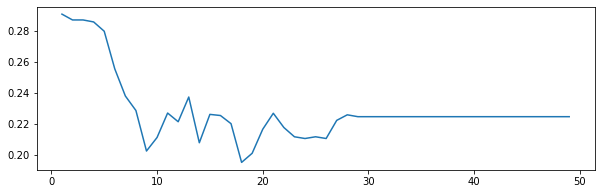

In [73]:
def draw_f1_DT(f1_dict):
    df1 = pd.DataFrame.from_dict(f1_dict,orient='index')
    display(df1.sort_values(by=df1.columns[0],ascending=False ).head(10))
    plt.plot(df1)
    #display(df1[df.columns[0]].max())
plt.rcParams['figure.figsize'] = (10,3)
draw_f1_DT(f1_valid_dict_DT)

На графике видно что на глубине дерева уровня 5 метрика начинает падать, т.к. деревья начинаю переобучаться

In [74]:
model_tree = DecisionTreeClassifier(random_state=890,max_depth=3)
model_tree.fit(X_train,y_train)
export_graphviz(model_tree, feature_names=X_train.columns, 
out_file='./deep_toy_tree.dot', filled=True)

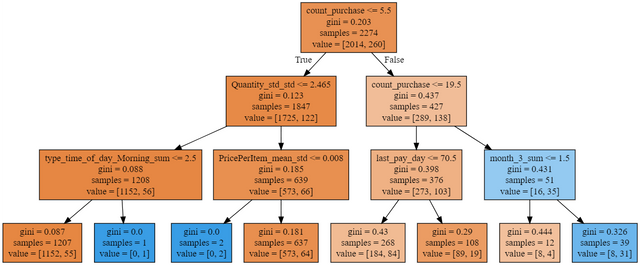

In [75]:
display1.Image("https://i.ibb.co/dpw15VC/graphviz.png",width=1278,height=533)

- На вход дерева поступает 2274 сэмпла и разделяются по параметру "количество покупок" по значению 5.5. Критерий джини - энтропия (мера снятия неопределенности) в данном узле. Чем ближе к 1 тем однозначней можно определить класс
- Потом идут свертки СКО с количетом товаров в чеке и количество покупок, но значение уже 19,5 и т.д. 

In [76]:
#расчет универсальных метрик для алгоритма
def metrics_calculate(X_train,y_train,X_valid,y_valid,predicted_valid,probabilities_valid = None):
    model_metrics = []
    tn, fp, fn, tp = confusion_matrix(y_valid,predicted_valid).ravel()
    precision = precision_score(y_valid,predicted_valid) 
    recall = recall_score(y_valid,predicted_valid)
    _f1_score = f1_score(y_valid,predicted_valid)
    accuracy = accuracy_score(y_valid,predicted_valid)
    #print(np.mean(probabilities_valid[:, 1]))
    model_metrics.append([tn, fp, fn, tp,precision,recall,_f1_score,accuracy])
    #model_metrics = pd.DataFrame(model_metrics,columns=['tn', 'fp', 'fn', 'tp','precision','recall','_f1_score'])
    #display(model_metrics)
    return np.hstack((model_metrics))

#перечень метрик для инициализации массива и формирования заголовка к DF
def list_metrics():
    metrics = ['tn', 'fp', 'fn', 'tp','precision','recall','_f1_score','accuracy']
    return metrics

#создадим график с pr кривой
def PR_curve(y_valid, probabilities_valid):
    precision, recall, thresholds = precision_recall_curve(y_valid, probabilities_valid[:, 1])
    plt.figure(figsize=(4, 4))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Кривая Precision-Recall')
    plt.show() 

# график ROC AUC кривой
def ROC_curve(y_valid,predicted_value_proba):
    fpr, tpr, thresholds = roc_curve(y_valid, predicted_value_proba[:,1])
    plt.figure()
    plt.plot(fpr,tpr)
    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
    #посчитаем  Area Under Curve ROC, площадь под кривой 
    auc_roc = roc_auc_score(y_valid, predicted_value_proba[:,1])
    print('Площадь под кривой AUC-ROC равна',auc_roc)
    
#функция выбора уставки
def threshold_selection(predicted_value,predict_proba,y_valid):
    #убедимся что мы все делаем правильно и при пороге 0.5 получаем тот же результат
    display(pd.Series((predict_proba[:,1]>0.5)).value_counts())
    display(pd.Series(predicted_value).value_counts())
    display(pd.Series(y_valid).value_counts())
    #возьмем массив с вероятностями и подберем порог
    probabilities_one_valid = predict_proba[:,1]
    score = []
    
    for threshold in np.arange(0.2, 0.7, 0.02):
        predicted_valid = pd.Series(probabilities_one_valid > threshold)
        _f1_score = f1_score(y_valid,predicted_valid)
        score.append([_f1_score,threshold])
    #преобразуем табличку с порогами, сортируем и выводим  
    score = pd.DataFrame(score,columns=['f1_score','threshold'])     
    display(score.sort_values(by =score.columns[0], ascending=False).head(20).T)
    ax =score.plot(x='threshold',y='f1_score',kind='line');
    plt.show()

In [77]:
%%time
def DecisionTreeClassifier_model(feature_train,target_train,feature_valid,target_valid):
    #созадим заголовок для таблицы метрик и кгиперпараметров
    metrics = np.hstack((list_metrics()+['depth','class_weight']))
    for weight1 in ['None','balanced']:
        for depth in range(2,20):
            if (weight1 == 'None'):
                weight1 = None
            model_DT = DecisionTreeClassifier(random_state=890,criterion='entropy',max_depth = depth,class_weight=weight1)
            model_DT.fit(feature_train,target_train)
            predict_DT = model_DT.predict(feature_valid)
            current_metrics = metrics_calculate( feature_train,target_train,feature_valid,target_valid,predict_DT,None)
            #добавим гиперпараметры в таблицу с метриками
            current_metrics = np.hstack((np.hstack((current_metrics,[depth,str(weight1)]))))
            metrics = np.vstack((metrics,current_metrics))
    #создадим таблицу со значениями метрик    
    metrics = pd.DataFrame(metrics,columns= metrics[0])
    metrics.drop(metrics.index[0],inplace=True)
    display(metrics.sort_values(by='_f1_score',ascending=False))
    return metrics
#вызовем построение модели  
metrics_DT =DecisionTreeClassifier_model(X_train_scale,y_train,X_valid_scale,y_valid)

,tn,fp,fn,tp,precision,recall,_f1_score,accuracy,depth,class_weight
19,564.0,108.0,53.0,33.0,0.23404255319148937,0.38372093023255816,0.29074889867841414,0.787598944591029,2,balanced
20,567.0,105.0,54.0,32.0,0.23357664233576642,0.37209302325581395,0.2869955156950673,0.7902374670184696,3,balanced
21,567.0,105.0,55.0,31.0,0.22794117647058823,0.36046511627906974,0.27927927927927926,0.7889182058047494,4,balanced
22,372.0,300.0,27.0,59.0,0.16434540389972144,0.686046511627907,0.2651685393258427,0.5686015831134564,5,balanced
23,484.0,188.0,45.0,41.0,0.17903930131004367,0.47674418604651164,0.2603174603174603,0.6926121372031663,6,balanced
24,519.0,153.0,51.0,35.0,0.18617021276595744,0.4069767441860465,0.25547445255474455,0.7308707124010554,7,balanced
26,453.0,219.0,44.0,42.0,0.16091954022988506,0.4883720930232558,0.2420749279538905,0.6530343007915568,9,balanced
25,426.0,246.0,41.0,45.0,0.15463917525773196,0.5232558139534884,0.2387267904509284,0.6213720316622692,8,balanced
13,609.0,63.0,66.0,20.0,0.24096385542168675,0.23255813953488372,0.2366863905325444,0.8298153034300791,14,None
16,593.0,79.0,64.0,22.0,0.21782178217821782,0.2558139534883721,0.23529411764705885,0.8113456464379947,17,None


Wall time: 1.06 s


#### RandomForestClassifier

In [78]:
%%time
def RandomForestClassifier_model(feature_train,target_train,feature_valid,target_valid):
    #созадим заголовок для таблицы метрик и гиперпараметров
    metrics = np.hstack((list_metrics()+['n_estimators']))
    for depth in range(5,15,3):
        for n_estimators in range(1,8,2):
            rfc = RandomForestClassifier(random_state=890, n_estimators= n_estimators);
            rfc.fit(feature_train,target_train);
            predict_valid = rfc.predict(feature_valid)
            current_metrics = metrics_calculate( feature_train,target_train,feature_valid,target_valid,predict_valid,None)
            #добавим гиперпараметры в таблицу с метриками
            current_metrics = np.hstack((np.hstack((current_metrics,[n_estimators]))))
            metrics = np.vstack((metrics,current_metrics))
        #print(metrics)
    #создадим таблицу со значениями метрик    
    metrics = pd.DataFrame(metrics,columns= metrics[0])
    metrics.drop(metrics.index[0],inplace=True)
    display(metrics.sort_values(by='_f1_score',ascending=False))
    return metrics
    
metrics_RF = RandomForestClassifier_model(X_train_scale,y_train,X_valid_scale,y_valid)

,tn,fp,fn,tp,precision,recall,_f1_score,accuracy,n_estimators
1,571.0,101.0,68.0,18.0,0.15126050420168066,0.20930232558139536,0.17560975609756097,0.7770448548812665,1.0
5,571.0,101.0,68.0,18.0,0.15126050420168066,0.20930232558139536,0.17560975609756097,0.7770448548812665,1.0
9,571.0,101.0,68.0,18.0,0.15126050420168066,0.20930232558139536,0.17560975609756097,0.7770448548812665,1.0
13,571.0,101.0,68.0,18.0,0.15126050420168066,0.20930232558139536,0.17560975609756097,0.7770448548812665,1.0
4,650.0,22.0,76.0,10.0,0.3125,0.11627906976744186,0.16949152542372883,0.8707124010554089,7.0
8,650.0,22.0,76.0,10.0,0.3125,0.11627906976744186,0.16949152542372883,0.8707124010554089,7.0
12,650.0,22.0,76.0,10.0,0.3125,0.11627906976744186,0.16949152542372883,0.8707124010554089,7.0
16,650.0,22.0,76.0,10.0,0.3125,0.11627906976744186,0.16949152542372883,0.8707124010554089,7.0
2,621.0,51.0,74.0,12.0,0.19047619047619047,0.13953488372093023,0.16107382550335567,0.8350923482849604,3.0
6,621.0,51.0,74.0,12.0,0.19047619047619047,0.13953488372093023,0.16107382550335567,0.8350923482849604,3.0


Wall time: 323 ms


 n_estimators — число «деревьев» в «случайном лесу».
<br> max_features — число признаков для выбора расщепления.
<br> max_depth — максимальная глубина деревьев.
<br> min_samples_split — минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться.
<br> min_samples_leaf — минимальное число объектов в листьях.
<br> bootstrap — использование для построения деревьев подвыборки с возвращением.

При значениях параметров n_iter = 10 и cv = 3, мы создали 30 RF-моделей, случайно выбирая комбинации представленных выше гиперпараметров.

In [79]:
#RandomizedSearchCV
rfc_2 = RandomForestClassifier(n_jobs=-1,
                            random_state=890)

# диапазоны для перебора будем брать 
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 1000, num = 50)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 3, stop = 20, num = 3)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 1)]
min_samples_leaf = range(3, 15,1)
bootstrap = [True, False]
criterion = ["gini", "entropy"]

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
                "criterion": criterion
             }
rs = RandomizedSearchCV(rfc_2, 
                        param_dist, 
                        n_iter = 100, # сейчас стоит 5 для теста, при финальных рассчетах поставим 20
                        cv = 5, 
                        verbose = 1, 
                        n_jobs=-1,
                        scoring = make_scorer(f1_score , average='macro'),
                        random_state=890)
rs.fit(X_train, y_train)
print(rs.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 5, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'log2', 'max_depth': 11, 'criterion': 'gini', 'bootstrap': True}


In [80]:
#посмотрим лучшие результаты RandomizedSearchCV
rs_df = pd.DataFrame(rs.cv_results_).sort_values(by='rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            #'mean_fit_time', 
            #'std_fit_time', 
            #'mean_score_time',
            #'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
display(rs_df.T)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
mean_fit_time,0.48,2.3,2.8,1.3,0.49,2,0.63,0.24,2.2,0.28,...,3.5,0.29,4.2,2.3,2.2,3.3,0.3,0.17,1.7,0.28
std_fit_time,0.33,0.73,0.45,0.25,0.064,0.53,0.1,0.13,0.38,0.026,...,0.18,0.096,0.48,0.14,0.11,0.49,0.085,0.054,0.48,0.0055
mean_score_time,0.047,0.32,0.47,0.23,0.1,0.43,0.1,0.12,0.18,0.15,...,0.56,0.088,0.42,0.27,0.18,0.31,0.13,0.25,0.33,0.055
std_score_time,0.019,0.24,0.25,0.089,0.078,0.17,0.022,0.04,0.021,0.1,...,0.16,0.025,0.053,0.026,0.025,0.07,0.049,0.33,0.16,0.0082
param_n_estimators,5,472,573,370,126,512,187,25,411,106,...,959,65,979,614,614,837,45,45,512,126
param_min_samples_split,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
param_min_samples_leaf,8,4,4,4,5,3,5,7,3,6,...,8,7,3,14,4,5,8,7,3,7
param_max_features,log2,sqrt,log2,log2,sqrt,log2,sqrt,sqrt,sqrt,sqrt,...,log2,sqrt,log2,sqrt,log2,sqrt,log2,log2,log2,log2
param_max_depth,11,20,20,20,20,20,20,11,11,11,...,3,3,3,3,3,3,3,3,3,3
param_criterion,gini,entropy,entropy,entropy,gini,entropy,gini,gini,gini,gini,...,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy


Результат после поyдбора параметрами RandomizedSearchCV и GridSearchCV для f1_score 0.2882882882882883
Результат после поyдбора параметрами RandomizedSearchCV и GridSearchCV для accuracy 0.8959156785243741


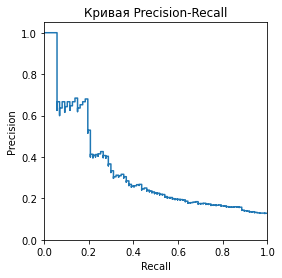

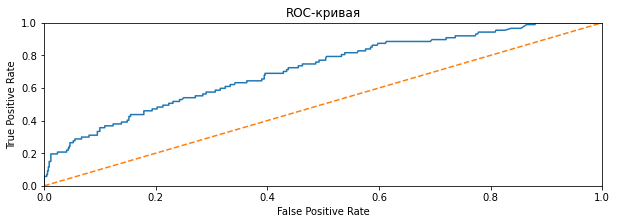

Площадь под кривой AUC-ROC равна 0.7123529009304871


In [81]:
#возьмем лучшие параметры после GridSearch
best_params = rs.best_params_
#best_params = rs.best_params_
def RandomForestClassifier_model(params,X_train, y_train,X_valid,y_valid):
    rfc_4 = RandomForestClassifier(**params)
    rfc_4.fit(X_train, y_train)
    predicted_value = rfc_4.predict(X_valid.values)
    predicted_value_proba = rfc_4.predict_proba(X_valid.values)
    _f1_score = f1_score(y_valid,predicted_value)
    print('Результат после поyдбора параметрами RandomizedSearchCV и GridSearchCV для f1_score', _f1_score)
    print('Результат после поyдбора параметрами RandomizedSearchCV и GridSearchCV для accuracy', accuracy_score(y_valid,predicted_value))
    #построим pr кривую PR(precision and recall)
    PR_curve(y_valid,predicted_value_proba)
    ROC_curve(y_valid,predicted_value_proba)
    return predicted_value,predicted_value_proba
predicted_value_RF,predicted_value_proba_RF = RandomForestClassifier_model(best_params,X_train,y_train,X_test,y_test)
plt.rcParams['figure.figsize'] = (15.0, 6.0)

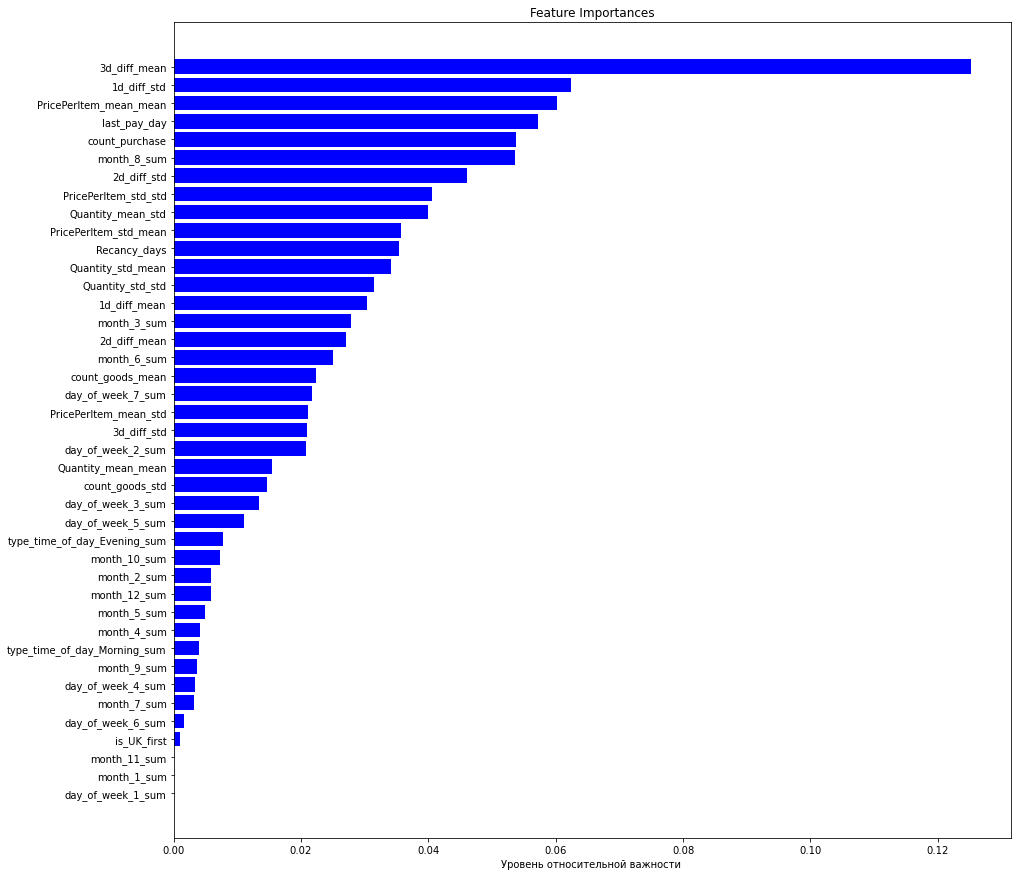

In [82]:
# посмотрим на вклад фичей в модели
plt.rcParams['figure.figsize'] = (15.0, 15.0)
rfc_4 = RandomForestClassifier(**best_params)
rfc_4.fit(X_train, y_train)
features=X_train.columns
importances = rfc_4.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Уровень относительной важности ')
plt.show()

**LogisticRegression**

In [83]:
%%time
def LogisticRegression_model(X_train,y_train,X_valid,y_valid):
    metrics = np.hstack((list_metrics()+['penalty']))
    for penalty in ['l1','l2']:
        model_LR = LogisticRegression(random_state=890,solver='liblinear',penalty = penalty,class_weight = 'balanced' )
        model_LR.fit(X_train,y_train);
        predict_proba_LR = model_LR.predict_proba(X_valid)
        predict_valid = model_LR.predict(X_valid)
        #metrics
        current_metrics = metrics_calculate( X_train,y_train,X_valid,y_valid,predict_valid,predict_proba_LR)
        #добавим гиперпараметры в таблицу с метриками
        current_metrics = np.hstack((np.hstack((current_metrics,[penalty]))))
        #добавим строчку с новыми метриками
        metrics = np.vstack((metrics,current_metrics))
       
    #создадим таблицу со значениями метрик  
    metrics = pd.DataFrame(metrics,columns= metrics[0])
    metrics.drop(metrics.index[0],inplace=True)
    display(metrics.sort_values(by='_f1_score',ascending=False))
    #sns.scatterplot(x= predict_valid,y=y_valid)
    #plt.title("LogisticRegression")
    #plt.xlabel('x')
    #plt.ylabel('y')
    #plt.show()
    return metrics
metrics_LR = LogisticRegression_model(X_train,y_train,X_valid,y_valid)

,tn,fp,fn,tp,precision,recall,_f1_score,accuracy,penalty
2,506.0,166.0,34.0,52.0,0.23853211009174313,0.6046511627906976,0.34210526315789475,0.7361477572559367,l2
1,506.0,166.0,35.0,51.0,0.2350230414746544,0.5930232558139535,0.3366336633663367,0.7348284960422163,l1


Wall time: 109 ms


In [84]:
%%time
def KNeighborsClassifier_model(feature_train,target_train,feature_valid,target_valid):
    neigbors = list(range(1,10)) +list(range(10,50,5))
    metrics = np.hstack((list_metrics()+['neigbors']))
    for neighbor in neigbors:
        knn_model = KNeighborsClassifier(n_neighbors =neighbor )
        #hold-out(отложенная выборка)
        knn_model.fit(feature_train,target_train)
        predict_valid = knn_model.predict(feature_valid)
        current_metrics = metrics_calculate( feature_train,target_train,feature_valid,target_valid,predict_valid,None)
        #добавим гиперпараметры в таблицу с метриками
        current_metrics = np.hstack((np.hstack((current_metrics,[neighbor]))))
        metrics = np.vstack((metrics,current_metrics))
    metrics = pd.DataFrame(metrics,columns= metrics[0])
    metrics.drop(metrics.index[0],inplace=True)
    display(metrics.sort_values(by='_f1_score',ascending=False))
    return metrics
     
metrics_KNN = KNeighborsClassifier_model(X_train,y_train,X_valid,y_valid)

,tn,fp,fn,tp,precision,recall,_f1_score,accuracy,neigbors
1,610.0,62.0,69.0,17.0,0.21518987341772153,0.19767441860465115,0.20606060606060608,0.8271767810026385,1.0
3,645.0,27.0,75.0,11.0,0.2894736842105263,0.12790697674418605,0.1774193548387097,0.8654353562005277,3.0
5,652.0,20.0,77.0,9.0,0.3103448275862069,0.10465116279069768,0.15652173913043477,0.8720316622691293,5.0
7,654.0,18.0,78.0,8.0,0.3076923076923077,0.09302325581395349,0.14285714285714285,0.8733509234828496,7.0
4,660.0,12.0,79.0,7.0,0.3684210526315789,0.08139534883720931,0.13333333333333336,0.8799472295514512,4.0
10,667.0,5.0,80.0,6.0,0.5454545454545454,0.06976744186046512,0.12371134020618556,0.8878627968337731,10.0
9,661.0,11.0,80.0,6.0,0.35294117647058826,0.06976744186046512,0.11650485436893203,0.8799472295514512,9.0
2,656.0,16.0,80.0,6.0,0.2727272727272727,0.06976744186046512,0.11111111111111109,0.8733509234828496,2.0
8,664.0,8.0,81.0,5.0,0.38461538461538464,0.05813953488372093,0.10101010101010101,0.8825857519788918,8.0
11,664.0,8.0,81.0,5.0,0.38461538461538464,0.05813953488372093,0.10101010101010101,0.8825857519788918,15.0


Wall time: 923 ms


### Обоснование выбора модели машинного обучения

Основными параметрами для выбора модели будут(в порядке убывания):
- интерпретируемость   
- точность метрики
- скорость работы алгоритма

Наилучшие результаты показала линейная регрессия. Но при схожем результате работу дерева решений обьяснить проще, т.к. нагляден алгоритм по которому происходит классификация. Алгоритм ближайших соседей хоть и показал хорошее ``accuracy``, но по ``F1`` метрике уступает деревьям.

## Проверка модели на тестовой выборке  <a id='сheсk'></a>

In [85]:
model_DT = DecisionTreeClassifier(random_state=890,max_depth=3,class_weight='balanced' )
model_DT.fit(X_train_scale,y_train)
predict = model_DT.predict(X_test_scale)
f1_test = f1_score(predict,y_test)
print("F1 score на тесте", f1_test)
print("accuracy score на тесте", accuracy_score(predict,y_test))

F1 score на тесте 0.3466666666666666
accuracy score на тесте 0.8063241106719368


## Расчет вероятностей покупки в следующем месяце <a id='prob'></a>

In [86]:
model_DT.fit(X_train,y_train)
predict = pd.DataFrame(model_DT.predict_proba(X),index=X.index)

In [87]:
predict_csv = predict.iloc[:,1].reset_index()
predict_csv.columns = ['CustomerID','prob']
predict_csv.to_csv('file_prob.csv',header=True, columns=['CustomerID','prob'], index=False, encoding='utf-8',float_format='%.5f')

## Примение моделей <a id='apply'></a>

- Результаты модели можно применить для "неопределившихся клиентов" т.е. у которых значение вероятности не находится в крайних пределах (0 или 1). Можно показывать им рекламу, слать письма и смс, звонить.
- Провести Uplift моделирование
- провести RFM (сегментация клиентов через алгоритмы кластеризации), LTV анализ
- разбить по категориям и прогнозировать отток по категориям

## Рекомендации по усовершенстованию моеделей <a id='improve'></a>

- оформить в виде пайплайнов записывать результаты эксперементов, обеспечеить воспроизводимость экспериментов
- провести рефакторинг кода, обернуть функции и добавить комментарии. Убрать часть которая связана с выводами данных. 
- В дальнейших работах можно предложить заказчику оптимизировать моделиь на метрике ``Precision`` (точность) т.к. нам нужно уменьшать количество ложно-позитивных клиентов (про которых модель говорит что они купят в следующем месяце, а на самом деле нет). 
- Можно подробней проанализировать признаки, почистить данные, построить диаграммы распределений, провести статистические тесты
- попробовать посредством NLP выделить классы товаров и учесть это при построении модели.
- при группировках можно было добавить фичей, но мы этого не делали, чтобы не усложнять модель

In [ ]:
просмотр кривых обучения, метрика logloss

In [ ]:
permutation feature importance 